In [11]:
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report


In [12]:
from pathlib import Path
import os

# 🔧 Project root directory (1 level up from current script)
ROOT = Path.cwd().parents[0]

# 🔹 Define input/output paths using ROOT
INPUT_CSV = ROOT / "datasets" / "cleaned" / "building_month_fire_panel_feat_eng.csv"
#OUTPUT_PANEL = ROOT / "datasets" / "cleaned" / "building_month_fire_panel_feat_eng.csv"

# 🔍 Optional: check existence6
print("[input exists?]", INPUT_CSV.exists(), "➜", INPUT_CSV)
#print("[output dir exists?]", OUTPUT_PANEL.parent.exists(), "➜", OUTPUT_PANEL.parent)


[input exists?] True ➜ C:\Users\mirei\OneDrive\Desktop\all-capstone-project-summer-2025-team-6\datasets\cleaned\building_month_fire_panel_feat_eng.csv


In [13]:
# 🔸 Load and clean fire dataset
df = pd.read_csv(INPUT_CSV)
df.head()

,ID_UEV,month,LATITUDE,LONGITUDE,MUNICIPALITE,ETAGE_HORS_SOL,NOMBRE_LOGEMENT,AGE_BATIMENT,CODE_UTILISATION,CATEGORIE_UEF,...,fire_last_2m,fire_last_3m,fire_cumcount,fire_rolling_3m,fire_rolling_6m,fire_rolling_12m,has_fire_last_month,months_since_last_fire,month_num,year
0,1000011,2020-01,45.504105,-73.564844,50,5.0,8.0,0.048913,1000,Régulier,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,999.0,1,2020
1,1000011,2020-02,45.504105,-73.564844,50,5.0,8.0,0.048913,1000,Régulier,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,999.0,2,2020
2,1000011,2020-03,45.504105,-73.564844,50,5.0,8.0,0.048913,1000,Régulier,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,999.0,3,2020
3,1000011,2020-04,45.504105,-73.564844,50,5.0,8.0,0.048913,1000,Régulier,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,999.0,4,2020
4,1000011,2020-05,45.504105,-73.564844,50,5.0,8.0,0.048913,1000,Régulier,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,999.0,5,2020


In [14]:
# 🔸 Load panel for modeling
df["month"] = pd.to_datetime(df["month"])
df = df.sort_values(["ID_UEV", "month"])
df["year"] = df["month"].dt.year

In [15]:

# 🔸 Add lag features
for lag in range(1, 4):
    df[f"fire_last_{lag}m"] = (
        df.groupby("ID_UEV")["HAS_FIRE_THIS_MONTH"]
        .shift(lag)
        .fillna(0)
        .astype(int)
    )

In [16]:
features = [
    "MUNICIPALITE", "ETAGE_HORS_SOL", "NOMBRE_LOGEMENT", "AGE_BATIMENT",
    "CODE_UTILISATION", "CATEGORIE_UEF", "SUPERFICIE_TERRAIN", "SUPERFICIE_BATIMENT",
    "NO_ARROND_ILE_CUM", "RATIO_SURFACE", "DENSITE_LOGEMENT", "HAS_MULTIPLE_LOGEMENTS",
    "FIRE_FREQUENCY_ZONE", "FIRE_RATE_ZONE", "FIRE_COUNT_LAST_YEAR_ZONE", "BUILDING_COUNT",
    "FIRE_RATE_ZONE_NORM", "FIRE_COUNT_LAST_YEAR_ZONE_NORM", 
    "fire_last_1m", "fire_last_2m", "fire_last_3m","fire_cumcount","fire_rolling_3m","fire_rolling_6m","fire_rolling_12m",
    "month_num", "year"  #,"season"
]
target = "HAS_FIRE_THIS_MONTH"

In [17]:
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# 🔹 Encode categorical variables
for col in ["CATEGORIE_UEF", "NO_ARROND_ILE_CUM"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# 🔹 Declare as categorical explicitly (for LightGBM performance boost)
df["CATEGORIE_UEF"] = df["CATEGORIE_UEF"].astype("category")
df["NO_ARROND_ILE_CUM"] = df["NO_ARROND_ILE_CUM"].astype("category")

# 🔹 Train-test split
train_df = df[df["year"] <= 2023]
test_df = df[df["year"] == 2024]

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

# ⚖️ Handle class imbalance
scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

# ✅ Train LightGBM model
model = LGBMClassifier(
    class_weight={0: 1, 1: scale_pos_weight},
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

model.fit(X_train, y_train)

# 📊 Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))


[LightGBM] [Info] Number of positive: 218348, number of negative: 14680228
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.492601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1719
[LightGBM] [Info] Number of data points in the train set: 14898576, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [18]:
y_probs = model.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_probs >= 0.2).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_thresh, digits=3))


              precision    recall  f1-score   support

           0      0.997     0.223     0.365   3674405
           1      0.017     0.958     0.033     50239

    accuracy                          0.233   3724644
   macro avg      0.507     0.591     0.199   3724644
weighted avg      0.984     0.233     0.360   3724644



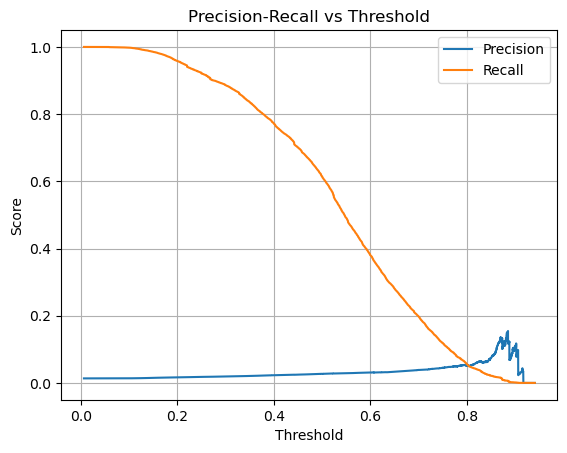

In [20]:
#Plot Precision vs Recall by Threshold
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

prec, rec, thresh = precision_recall_curve(y_test, y_probs)

plt.plot(thresh, prec[:-1], label='Precision')
plt.plot(thresh, rec[:-1], label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
#select an optimal threshold based on F2-score (emphasizing recall):

from sklearn.metrics import fbeta_score
import numpy as np

best_thresh = 0.0
best_f2 = 0.0

for t in np.arange(0.05, 0.95, 0.01):
    y_pred_t = (y_probs >= t).astype(int)
    f2 = fbeta_score(y_test, y_pred_t, beta=2)
    if f2 > best_f2:
        best_f2 = f2
        best_thresh = t
    print(f"Threshold {t:.2f} → F2 Score: {f2:.4f}")

print(f"\n✅ Best Threshold (by F2): {best_thresh:.2f} with F2 Score: {best_f2:.4f}")


Threshold 0.05 → F2 Score: 0.0641
Threshold 0.06 → F2 Score: 0.0642
Threshold 0.07 → F2 Score: 0.0643
Threshold 0.08 → F2 Score: 0.0645
Threshold 0.09 → F2 Score: 0.0647
Threshold 0.10 → F2 Score: 0.0652
Threshold 0.11 → F2 Score: 0.0658
Threshold 0.12 → F2 Score: 0.0668
Threshold 0.13 → F2 Score: 0.0680
Threshold 0.14 → F2 Score: 0.0694
Threshold 0.15 → F2 Score: 0.0711
Threshold 0.16 → F2 Score: 0.0727
Threshold 0.17 → F2 Score: 0.0740
Threshold 0.18 → F2 Score: 0.0752
Threshold 0.19 → F2 Score: 0.0764
Threshold 0.20 → F2 Score: 0.0775
Threshold 0.21 → F2 Score: 0.0787
Threshold 0.22 → F2 Score: 0.0795
Threshold 0.23 → F2 Score: 0.0808
Threshold 0.24 → F2 Score: 0.0821
Threshold 0.25 → F2 Score: 0.0832
Threshold 0.26 → F2 Score: 0.0844
Threshold 0.27 → F2 Score: 0.0850
Threshold 0.28 → F2 Score: 0.0861
Threshold 0.29 → F2 Score: 0.0873
Threshold 0.30 → F2 Score: 0.0885
Threshold 0.31 → F2 Score: 0.0896
Threshold 0.32 → F2 Score: 0.0907
Threshold 0.33 → F2 Score: 0.0917
Threshold 0.34

Optimal Threshold: 0.58
At this point:

F2 score is highest: 0.1173

It balances recall and precision with more weight on recall.

Likely the best operating point if you care more about catching fires, but want to reduce false positives compared to using threshold = 0.2 or 0.3.

 What Happens at Threshold = 0.58?
Let’s break it down:

Metric	Effect at 0.58
Recall	Still reasonably high
Precision	Improved compared to thresholds ≤ 0.3
F2	Highest overall
F1	Likely better than very low thresholds
False Alarms	Reduced, compared to 0.2

It’s a very good compromise: the model still captures a majority of fire cases but avoids flooding your system with false alerts.

In [23]:
y_pred_final = (y_probs >= 0.58).astype(int)
print(classification_report(y_test, y_pred_final, digits=3))


              precision    recall  f1-score   support

           0      0.990     0.813     0.893   3674405
           1      0.030     0.424     0.056     50239

    accuracy                          0.808   3724644
   macro avg      0.510     0.619     0.475   3724644
weighted avg      0.977     0.808     0.882   3724644



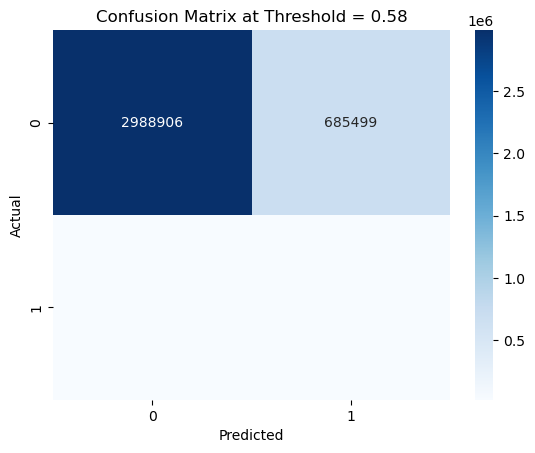

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix at Threshold = 0.58")
plt.show()


 LightGBM does not clearly outperform XGBoost in terms of recall, precision, or interpretability.
    
    🔥 In your fire-risk prediction case:
XGBoost Pros:
Slightly better recall (which is more important for rare event detection).

Slightly more mature ecosystem for imbalanced classification (e.g. scale_pos_weight, better calibrated probabilities).

More robust handling of imbalanced tabular data "out of the box".

LightGBM Pros:
Slightly better precision and F2 — a marginal win.

Might train faster if you scale up (you already have ~15M rows).

💡 Bottom Line
❗There is no significant added value in switching from XGBoost to LightGBM in your current workflow.
Unless:

You want to speed up training over much larger datasets.

You find LightGBM easier to tune and deploy.

You're using features or platforms that favor LightGBM (e.g., Azure AutoML, native categorical handling in Optuna).

✅ Recommendation
✅ Stick with XGBoost for now if recall is critical.

✅ Use LightGBM only if:

you are exploring new features and faster iterations,

you want to ensemble both (which can help),

or you're targeting production environments with strict latency.
